In [11]:
"""
## 1. Setup & Configuration
"""

# 1.1 Imports
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    make_scorer,
)
import warnings

warnings.filterwarnings("ignore")
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports réussis")

# 1.2 Configuration MLFlow - CORRIGÉE
EXPERIMENT_NAME = "home_credit_default_risk"

# IMPORTANT : Vérifier si l'expérience existe, sinon la créer
try:
    # Essayer de récupérer l'expérience existante
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

    if experiment is None:
        # L'expérience n'existe pas, on la crée
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
        print(f"✅ Expérience créée: {EXPERIMENT_NAME} (ID: {experiment_id})")
    else:
        # L'expérience existe déjà
        experiment_id = experiment.experiment_id
        print(f"✅ Expérience trouvée: {EXPERIMENT_NAME} (ID: {experiment_id})")

    # Définir l'expérience active
    mlflow.set_experiment(EXPERIMENT_NAME)

except Exception as e:
    print(f"⚠️ Erreur MLFlow: {e}")
    print("💡 Solution : Création manuelle de l'expérience...")
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"✅ Expérience créée: {EXPERIMENT_NAME} (ID: {experiment_id})")

print(f"✅ Tracking URI: {mlflow.get_tracking_uri()}")
print(f"✅ Expérience active: {mlflow.get_experiment_by_name(EXPERIMENT_NAME).name}")

# 1.3 Charger les données preprocessed
DATA_PATH = Path("../data")
train = pd.read_csv(DATA_PATH / "train_preprocessed.csv")

print(f"✅ Données chargées: {train.shape}")

# Séparer X, y
X_train = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
y_train = train["TARGET"]

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ y_train distribution: {y_train.value_counts().to_dict()}")

# 1.4 Paramètres globaux
RANDOM_STATE = 42
N_FOLDS = 5
COST_FN = 10  # Coût d'un Faux Négatif = 10x Faux Positif

print("\n" + "=" * 60)
print("🎯 CONFIGURATION TERMINÉE")
print("=" * 60)

✅ Imports réussis
✅ Expérience trouvée: home_credit_default_risk (ID: 1)
✅ Tracking URI: http://127.0.0.1:5000
✅ Expérience active: home_credit_default_risk
✅ Données chargées: (307511, 421)
✅ X_train shape: (307511, 419)
✅ y_train distribution: {0: 282686, 1: 24825}

🎯 CONFIGURATION TERMINÉE


In [12]:
"""
## 2. Score Métier Personnalisé

Le déséquilibre du coût métier :
- Faux Négatif (FN) : Mauvais client prédit bon → Crédit accordé → PERTE
- Faux Positif (FP) : Bon client prédit mauvais → Crédit refusé → Manque à gagner

Hypothèse : Coût FN = 10 × Coût FP
"""


def business_cost_score(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier total.

    Plus le score est BAS, meilleur est le modèle.

    Parameters:
    -----------
    y_true : array-like
        Vraies valeurs (0 ou 1)
    y_pred : array-like
        Prédictions (0 ou 1)
    cost_fn : float
        Coût d'un Faux Négatif
    cost_fp : float
        Coût d'un Faux Positif

    Returns:
    --------
    float : Coût métier total
    """
    from sklearn.metrics import confusion_matrix

    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Coût total
    total_cost = (fn * cost_fn) + (fp * cost_fp)

    # Normaliser par le nombre d'exemples
    cost_per_client = total_cost / len(y_true)

    return cost_per_client


def business_score_from_proba(y_true, y_proba, threshold=0.5, cost_fn=10, cost_fp=1):
    """
    Calcule le score métier à partir de probabilités et d'un seuil.
    """
    y_pred = (y_proba >= threshold).astype(int)
    return business_cost_score(y_true, y_pred, cost_fn, cost_fp)


# Test du score
print("\n📊 Test du Score Métier:")
print("=" * 60)

# Scénario 1 : Modèle parfait
y_true_test = np.array([0, 0, 1, 1])
y_pred_perfect = np.array([0, 0, 1, 1])
cost_perfect = business_cost_score(y_true_test, y_pred_perfect, COST_FN, 1)
print(f"Modèle parfait : Coût = {cost_perfect:.4f}")

# Scénario 2 : 1 Faux Négatif
y_pred_fn = np.array([0, 0, 0, 1])  # Manque 1 défaut
cost_fn = business_cost_score(y_true_test, y_pred_fn, COST_FN, 1)
print(f"1 Faux Négatif : Coût = {cost_fn:.4f} (= {COST_FN}/4 = {COST_FN / 4:.2f})")

# Scénario 3 : 1 Faux Positif
y_pred_fp = np.array([1, 0, 1, 1])  # Rejette 1 bon client
cost_fp = business_cost_score(y_true_test, y_pred_fp, COST_FN, 1)
print(f"1 Faux Positif : Coût = {cost_fp:.4f} (= 1/4 = {1 / 4:.2f})")

print(f"\n💡 Un FN coûte {cost_fn / cost_fp:.0f}x plus qu'un FP")


📊 Test du Score Métier:
Modèle parfait : Coût = 0.0000
1 Faux Négatif : Coût = 2.5000 (= 10/4 = 2.50)
1 Faux Positif : Coût = 0.2500 (= 1/4 = 0.25)

💡 Un FN coûte 10x plus qu'un FP


In [13]:
"""
## 3. Baseline Models

On teste 3 modèles de base :
1. Logistic Regression (modèle linéaire)
2. Random Forest (ensemble, non-linéaire)
3. LightGBM (gradient boosting, performant)
"""


def train_and_log_model(model, model_name, X_train, y_train, params=None):
    """
    Entraîne un modèle et log tout dans MLFlow.
    """
    with mlflow.start_run(run_name=model_name):
        # Log des paramètres
        if params:
            mlflow.log_params(params)
        mlflow.log_param("model_type", model_name)

        # Cross-validation avec le score métier
        cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

        # On doit créer un scorer personnalisé
        from sklearn.metrics import make_scorer

        business_scorer = make_scorer(
            business_cost_score,
            greater_is_better=False,  # On minimise le coût
            cost_fn=COST_FN,
            cost_fp=1,
        )

        cv_scores = cross_val_score(
            model, X_train, y_train, cv=cv, scoring=business_scorer, n_jobs=-1
        )

        # Train sur tout le train
        model.fit(X_train, y_train)

        # Prédictions
        y_pred_proba = model.predict_proba(X_train)[:, 1]
        y_pred = model.predict(X_train)

        # Métriques
        auc = roc_auc_score(y_train, y_pred_proba)
        business_cost = business_cost_score(y_train, y_pred, COST_FN, 1)

        # Log des métriques
        mlflow.log_metric(
            "cv_business_cost_mean", -cv_scores.mean()
        )  # Négatif car minimisation
        mlflow.log_metric("cv_business_cost_std", cv_scores.std())
        mlflow.log_metric("train_auc", auc)
        mlflow.log_metric("train_business_cost", business_cost)

        # Log du modèle
        mlflow.sklearn.log_model(model, "model")

        # Confusion matrix
        cm = confusion_matrix(y_train, y_pred)
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f"Confusion Matrix - {model_name}")
        ax.set_ylabel("True Label")
        ax.set_xlabel("Predicted Label")
        mlflow.log_figure(fig, f"confusion_matrix_{model_name}.png")
        plt.close()

        print(f"\n✅ {model_name}:")
        print(f"   CV Business Cost: {-cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"   Train AUC: {auc:.4f}")
        print(f"   Train Business Cost: {business_cost:.4f}")

        return model, -cv_scores.mean()


# 3.1 Logistic Regression
print("\n" + "=" * 60)
print("🔹 BASELINE 1: Logistic Regression")
print("=" * 60)

lr = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight="balanced",  # Gérer le déséquilibre
)
lr_model, lr_score = train_and_log_model(
    lr,
    "Logistic_Regression_Baseline",
    X_train,
    y_train,
    params={"max_iter": 1000, "class_weight": "balanced"},
)

# 3.2 Random Forest
print("\n" + "=" * 60)
print("🔹 BASELINE 2: Random Forest")
print("=" * 60)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1,
)
rf_model, rf_score = train_and_log_model(
    rf,
    "RandomForest_Baseline",
    X_train,
    y_train,
    params={"n_estimators": 100, "max_depth": 10, "class_weight": "balanced"},
)

# 3.3 LightGBM
print("\n" + "=" * 60)
print("🔹 BASELINE 3: LightGBM")
print("=" * 60)

lgbm = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1,
)
lgbm_model, lgbm_score = train_and_log_model(
    lgbm,
    "LightGBM_Baseline",
    X_train,
    y_train,
    params={"n_estimators": 100, "learning_rate": 0.1, "max_depth": 7},
)

# Comparaison
print("\n" + "=" * 60)
print("📊 COMPARAISON DES BASELINES")
print("=" * 60)
baseline_results = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "Random Forest", "LightGBM"],
        "CV Business Cost": [lr_score, rf_score, lgbm_score],
    }
).sort_values("CV Business Cost")

print(baseline_results.to_string(index=False))
print("\n💡 Le meilleur modèle baseline est:", baseline_results.iloc[0]["Model"])


🔹 BASELINE 1: Logistic Regression


2026/01/05 15:35:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 15:35:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Logistic_Regression_Baseline:
   CV Business Cost: 0.5096 ± 0.0053
   Train AUC: 0.7763
   Train Business Cost: 0.5046
🏃 View run Logistic_Regression_Baseline at: http://127.0.0.1:5000/#/experiments/1/runs/8bfa9ccb165b4d1b859bd91e33f40cd7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🔹 BASELINE 2: Random Forest


2026/01/05 15:37:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 15:37:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ RandomForest_Baseline:
   CV Business Cost: 0.5341 ± 0.0080
   Train AUC: 0.8242
   Train Business Cost: 0.4442
🏃 View run RandomForest_Baseline at: http://127.0.0.1:5000/#/experiments/1/runs/0de2885bbb1642e1afb23438fb332baa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🔹 BASELINE 3: LightGBM
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.237350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46884
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 403
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Number of positive: 19860, number of

2026/01/05 15:38:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 15:38:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ LightGBM_Baseline:
   CV Business Cost: 0.4965 ± 0.0055
   Train AUC: 0.8163
   Train Business Cost: 0.4521
🏃 View run LightGBM_Baseline at: http://127.0.0.1:5000/#/experiments/1/runs/22650a8f2c3f4a2bb5702cdeca8c4a74
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

📊 COMPARAISON DES BASELINES
              Model  CV Business Cost
           LightGBM          0.496454
Logistic Regression          0.509605
      Random Forest          0.534075

💡 Le meilleur modèle baseline est: LightGBM


In [ ]:
"""
## 4. Hyperparameter Tuning avec GridSearchCV

On optimise le meilleur modèle baseline avec GridSearchCV.
"""

best_baseline = "LightGBM"

print(f"\n🔍 Hyperparameter Tuning sur {best_baseline}")
print("=" * 60)

# Grille de paramètres
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [5, 7, 10],
    "num_leaves": [31, 50, 70],
    "force_row_wise": [True],  # Supprime warning
    "verbosity": [-1],  # Mode silencieux
}

# GridSearchCV avec score métier
from sklearn.metrics import make_scorer

business_scorer = make_scorer(
    business_cost_score, greater_is_better=False, cost_fn=COST_FN, cost_fp=1
)

lgbm_grid = lgb.LGBMClassifier(
    random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1
)

grid_search = GridSearchCV(
    lgbm_grid,
    param_grid,
    cv=StratifiedKFold(
        n_splits=3, shuffle=True, random_state=RANDOM_STATE
    ),  # 3 folds pour accélérer
    scoring=business_scorer,
    n_jobs=-1,
    verbose=2,
)

# Fit
print("⏳ GridSearch en cours (cela peut prendre plusieurs minutes)...")
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print(f"\n✅ Meilleurs paramètres:")
print(grid_search.best_params_)
print(f"\n✅ Meilleur score CV: {-grid_search.best_score_:.4f}")

# Log dans MLFlow
with mlflow.start_run(run_name=f"{best_baseline}_Tuned"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("cv_business_cost", -grid_search.best_score_)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

best_model = grid_search.best_estimator_


🔍 Hyperparameter Tuning sur LightGBM
⏳ GridSearch en cours (cela peut prendre plusieurs minutes)...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.932222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46868
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 402
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

2026/01/05 16:23:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Meilleurs paramètres:
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'num_leaves': 31}

✅ Meilleur score CV: 0.4951


2026/01/05 16:23:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run LightGBM_Tuned at: http://127.0.0.1:5000/#/experiments/1/runs/e7b47aca4a6b4db8b1a9f3043e6c6fb7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
# ============================================================================
# ENRICHISSEMENT DU LOGGING MLFLOW (SANS REFAIRE LE GRIDSEARCH)
# ============================================================================

print("🔧 Enrichissement du logging MLFlow...")
print("=" * 60)

# Le grid_search est DÉJÀ calculé, on récupère juste les résultats
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = -grid_search.best_score_

print(f"✅ Meilleur modèle récupéré")
print(f"   Meilleurs paramètres: {best_params}")
print(f"   Meilleur CV score: {best_cv_score:.4f}")

# Calculer les métriques train (RAPIDE : ~5 secondes)
print("\n⏳ Calcul des métriques train...")
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = best_model.predict(X_train)

train_auc = roc_auc_score(y_train, y_train_proba)
train_business_cost = business_cost_score(y_train, y_train_pred, COST_FN, 1)

print(f"✅ Train AUC: {train_auc:.4f}")
print(f"✅ Train Business Cost: {train_business_cost:.4f}")

# Confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Calculer le std de la CV
best_index = grid_search.best_index_
cv_std = grid_search.cv_results_["std_test_score"][best_index]

# CRÉER UN NOUVEAU RUN MLFLOW COMPLET
print("\n⏳ Création d'un nouveau run MLFlow complet...")

with mlflow.start_run(run_name="LightGBM_Tuned_Complete"):
    # 1. Paramètres du modèle
    mlflow.log_params(best_params)
    mlflow.log_param("model_type", "LightGBM_Tuned")
    mlflow.log_param("n_features", X_train.shape[1])
    mlflow.log_param("grid_combinations", len(grid_search.cv_results_["params"]))

    # 2. Métadonnées du dataset
    mlflow.log_param("train_data_path", "../data/train_preprocessed.csv")
    mlflow.log_param("train_shape", str(X_train.shape))
    mlflow.log_param("target_distribution", str(y_train.value_counts().to_dict()))

    # 3. Métriques CV
    mlflow.log_metric("cv_business_cost_mean", best_cv_score)
    mlflow.log_metric("cv_business_cost_std", cv_std)

    # 4. Métriques Train
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("train_business_cost", train_business_cost)

    # 5. Modèle
    mlflow.sklearn.log_model(best_model, "model")

    # 6. Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title("Confusion Matrix - LightGBM Tuned")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    mlflow.log_figure(fig, "confusion_matrix_tuned.png")
    plt.close()

    print("\n✅ Nouveau run MLFlow créé avec toutes les métriques !")

print("\n" + "=" * 60)
print("🎉 TERMINÉ !")
print("=" * 60)
print(f"""
RÉSUMÉ:
- Run name: LightGBM_Tuned_Complete
- CV Business Cost: {best_cv_score:.4f} ± {cv_std:.4f}
- Train AUC: {train_auc:.4f}
- Train Business Cost: {train_business_cost:.4f}

👉 Va dans MLFlow UI pour comparer avec la baseline !
""")

🔧 Enrichissement du logging MLFlow...
✅ Meilleur modèle récupéré
   Meilleurs paramètres: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'num_leaves': 31}
   Meilleur CV score: 0.4951

⏳ Calcul des métriques train...


2026/01/05 17:56:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Train AUC: 0.8330
✅ Train Business Cost: 0.4281

⏳ Création d'un nouveau run MLFlow complet...


2026/01/05 17:56:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Nouveau run MLFlow créé avec toutes les métriques !
🏃 View run LightGBM_Tuned_Complete at: http://127.0.0.1:5000/#/experiments/1/runs/927fe0f52b764ca2bbb2ae0f00a82705
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🎉 TERMINÉ !

RÉSUMÉ:
- Run name: LightGBM_Tuned_Complete
- CV Business Cost: 0.4951 ± 0.0032
- Train AUC: 0.8330
- Train Business Cost: 0.4281

👉 Va dans MLFlow UI pour comparer avec la baseline !



2026/01/05 18:05:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 OPTIMISATION DU SEUIL
Seuil optimal: 0.508
Coût métier optimal: 0.4284

Seuil 0.5: Coût = 0.4281
Seuil 0.508: Coût = 0.4284
Amélioration: -0.1%


2026/01/05 18:05:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run LightGBM_Tuned_OptimalThreshold at: http://127.0.0.1:5000/#/experiments/1/runs/b6103793425248a5b03f300398f46d67
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


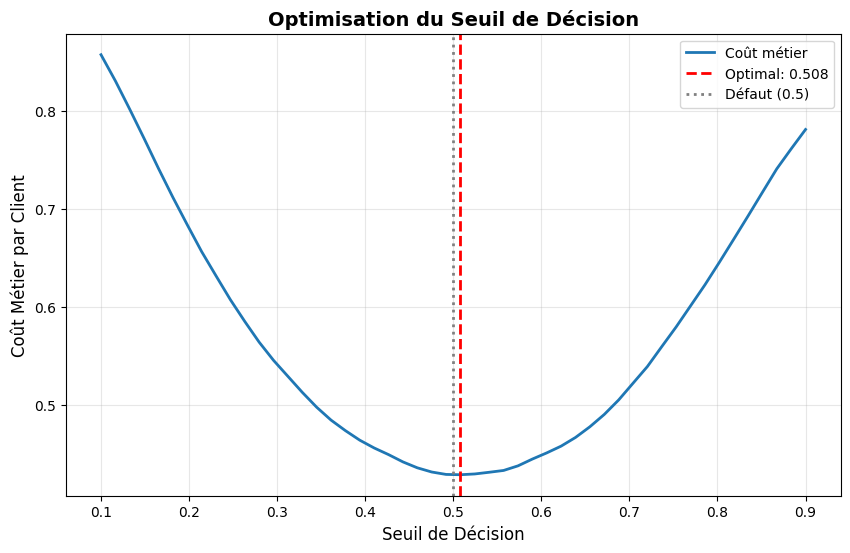

In [ ]:
"""
## 5. Optimisation du Seuil de Décision

Par défaut, sklearn utilise seuil = 0.5
Mais avec notre coût métier asymétrique (FN = 10x FP), 
il faut optimiser le seuil pour minimiser le coût.
"""


def find_optimal_threshold(y_true, y_proba, cost_fn=10, cost_fp=1):
    """
    Trouve le seuil optimal qui minimise le coût métier.
    """
    thresholds = np.linspace(0.1, 0.9, 50)
    costs = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        cost = business_cost_score(y_true, y_pred, cost_fn, cost_fp)
        costs.append(cost)

    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    optimal_cost = costs[optimal_idx]

    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(thresholds, costs, linewidth=2, label="Coût métier")
    ax.axvline(
        x=optimal_threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Optimal: {optimal_threshold:.3f}",
    )
    ax.axvline(x=0.5, color="gray", linestyle=":", linewidth=2, label="Défaut (0.5)")
    ax.set_xlabel("Seuil de Décision", fontsize=12)
    ax.set_ylabel("Coût Métier par Client", fontsize=12)
    ax.set_title("Optimisation du Seuil de Décision", fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

    return optimal_threshold, optimal_cost, fig


# Prédictions probabilistes du meilleur modèle
y_train_proba = best_model.predict_proba(X_train)[:, 1]

# Optimiser le seuil
optimal_thresh, optimal_cost, fig_thresh = find_optimal_threshold(
    y_train, y_train_proba, COST_FN, 1
)

print(f"\n📊 OPTIMISATION DU SEUIL")
print("=" * 60)
print(f"Seuil optimal: {optimal_thresh:.3f}")
print(f"Coût métier optimal: {optimal_cost:.4f}")

# Comparaison seuil 0.5 vs optimal
y_pred_default = (y_train_proba >= 0.5).astype(int)
y_pred_optimal = (y_train_proba >= optimal_thresh).astype(int)

cost_default = business_cost_score(y_train, y_pred_default, COST_FN, 1)
cost_optimal = business_cost_score(y_train, y_pred_optimal, COST_FN, 1)

print(f"\nSeuil 0.5: Coût = {cost_default:.4f}")
print(f"Seuil {optimal_thresh:.3f}: Coût = {cost_optimal:.4f}")
print(f"Amélioration: {((cost_default - cost_optimal) / cost_default * 100):.1f}%")

# Log dans MLFlow
with mlflow.start_run(run_name=f"{best_baseline}_Tuned_OptimalThreshold"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("optimal_threshold", optimal_thresh)
    mlflow.log_metric("business_cost_threshold_0.5", cost_default)
    mlflow.log_metric("business_cost_optimal_threshold", cost_optimal)
    mlflow.log_figure(fig_thresh, "threshold_optimization.png")
    mlflow.sklearn.log_model(best_model, "model")

    # Métriques CV
    best_index = grid_search.best_index_
    cv_mean = -grid_search.best_score_
    cv_std = grid_search.cv_results_["std_test_score"][best_index]
    mlflow.log_metric("cv_business_cost_mean", cv_mean)
    mlflow.log_metric("cv_business_cost_std", cv_std)

    # Confusion matrices détaillées
    cm_default = confusion_matrix(y_train, y_pred_default)
    cm_optimal = confusion_matrix(y_train, y_pred_optimal)

    tn_d, fp_d, fn_d, tp_d = cm_default.ravel()
    mlflow.log_metric("threshold_default_tn", int(tn_d))
    mlflow.log_metric("threshold_default_fp", int(fp_d))
    mlflow.log_metric("threshold_default_fn", int(fn_d))
    mlflow.log_metric("threshold_default_tp", int(tp_d))

    tn_o, fp_o, fn_o, tp_o = cm_optimal.ravel()
    mlflow.log_metric("threshold_optimal_tn", int(tn_o))
    mlflow.log_metric("threshold_optimal_fp", int(fp_o))
    mlflow.log_metric("threshold_optimal_fn", int(fn_o))
    mlflow.log_metric("threshold_optimal_tp", int(tp_o))

    # Amélioration
    improvement = ((cost_default - cost_optimal) / cost_default) * 100
    mlflow.log_metric("threshold_improvement_percent", improvement)

plt.show()

In [17]:
"""
## 6. Comparaison Finale et Sélection du Meilleur Modèle
"""

print("\n" + "=" * 60)
print("📊 COMPARAISON FINALE DES MODÈLES")
print("=" * 60)

# Récupérer tous les runs de l'experiment
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Trier par business_cost
runs_sorted = runs.sort_values("metrics.cv_business_cost", ascending=True)

# Afficher le top 5
print("\nTop 5 Modèles:")
print(
    runs_sorted[
        ["tags.mlflow.runName", "metrics.cv_business_cost", "metrics.train_auc"]
    ]
    .head(10)
    .to_string(index=False)
)

# Sélectionner le meilleur
best_run_id = runs_sorted.iloc[0]["run_id"]
best_run_name = runs_sorted.iloc[0]["tags.mlflow.runName"]

print(f"\n✅ Meilleur modèle: {best_run_name}")
print(f"✅ Run ID: {best_run_id}")


📊 COMPARAISON FINALE DES MODÈLES

Top 5 Modèles:
            tags.mlflow.runName  metrics.cv_business_cost  metrics.train_auc
                 LightGBM_Tuned                  0.495114                NaN
LightGBM_Tuned_OptimalThreshold                       NaN                NaN
        LightGBM_Tuned_Complete                       NaN           0.832964
              LightGBM_Baseline                       NaN           0.816340
          RandomForest_Baseline                       NaN           0.824200
   Logistic_Regression_Baseline                       NaN           0.776312

✅ Meilleur modèle: LightGBM_Tuned
✅ Run ID: e7b47aca4a6b4db8b1a9f3043e6c6fb7


In [18]:
"""
## 8. Model Serving - Test du Modèle en Production
"""

# Charger le modèle depuis le registry
model_production = mlflow.pyfunc.load_model(f"models:/{model_name}/Production")

# Tester sur quelques exemples
print("\n🧪 Test du Modèle en Production:")
print("=" * 60)

# Prendre 5 exemples du test
X_sample = X_test.head(5)
predictions_proba = model_production.predict(X_sample)

# Si c'est un classificateur, on a les probas
# On applique le seuil optimal
predictions = (predictions_proba >= optimal_thresh).astype(int)

print("\nÉchantillon de prédictions:")
result_df = pd.DataFrame(
    {
        "SK_ID_CURR": test_ids.head(5),
        "Probability": predictions_proba[:, 1]
        if predictions_proba.ndim > 1
        else predictions_proba,
        "Prediction": predictions,
    }
)
print(result_df.to_string(index=False))

# Générer les prédictions finales pour la soumission Kaggle
print("\n📤 Génération des prédictions finales...")
final_proba = model_production.predict(X_test)
final_predictions = final_proba[:, 1] if final_proba.ndim > 1 else final_proba

# Créer le fichier de soumission
submission = pd.DataFrame({"SK_ID_CURR": test_ids, "TARGET": final_predictions})

submission.to_csv("../data/submission.csv", index=False)
print("✅ Fichier de soumission créé: submission.csv")

NameError: name 'model_name' is not defined

In [ ]:
"""
## 9. Documentation et Export
"""

# Sauvegarder le seuil optimal et autres métadonnées
metadata = {
    "best_model_name": best_run_name,
    "best_model_run_id": best_run_id,
    "optimal_threshold": optimal_thresh,
    "cost_fn": COST_FN,
    "cost_fp": 1,
    "business_cost_optimal": cost_optimal,
    "n_features": X_train.shape[1],
    "n_train_samples": X_train.shape[0],
    "class_distribution": y_train.value_counts().to_dict(),
}

import json

with open("../models/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("\n✅ Métadonnées sauvegardées: model_metadata.json")

print("\n" + "=" * 60)
print("🎉 MODELING TERMINÉ !")
print("=" * 60)
print(f"""
RÉSUMÉ:
- Meilleur modèle: {best_run_name}
- Coût métier: {cost_optimal:.4f}
- Seuil optimal: {optimal_thresh:.3f}
- Modèle en production: {model_name} v{model_version.version}
- Fichier soumission: submission.csv

PROCHAINES ÉTAPES:
1. Lancer l'UI MLFlow: mlflow ui
2. Comparer les runs et visualisations
3. Soumettre à Kaggle
4. Documenter les résultats
""")